## KNN Model

In [2]:
## Import need packages 
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Dropout

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
def create_model(units=60, dropout=0, reg=None):
    model = Sequential()
    model.add(Dense(12, input_shape=(1000,), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(units, activation='relu', kernel_regularizer = reg))
    model.add(Dropout(dropout))
 
    
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
dataset = pd.read_pickle("../data/dataset_df.pkl")

In [35]:
dataset.head()

,pname,key,summary,description,space,features,features_fixed,label
0,Books,BK-1,"In the Picture of Dorian Gray, do you think th...",,,"In the Picture of Dorian Gray, do you think th...","in the picture of dorian gray, do you think th...",0
1,Books,BK-2,bb,,,bb,bb,0
2,Books,BK-3,Need some advice from book experts,I got a lot of books at the moment and my book...,,Need some advice from book experts I got a lot...,need some advice from book experts i got a lot...,0
3,Books,BK-4,Can we talk about The Invisible Life Of Addie ...,I want to preface this with saying that *The I...,,Can we talk about The Invisible Life Of Addie ...,can we talk about the invisible life of addie ...,0
4,Books,BK-5,I Forgot a book and I want to read it again,,,I Forgot a book and I want to read it again,i forgot a book and i want to read it again,0


In [36]:
X = dataset['features_fixed']
y = dataset['label']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=251)

In [38]:
# using TfidfVectorizer and vectorizing both test and train data 
tf_vect = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_trans = tf_vect.fit_transform(X_train)
X_test_trans = tf_vect.transform(X_test)
X_train_trans = X_train_trans.toarray()
X_test_trans = X_test_trans.toarray()

In [39]:
X_train_trans.shape, X_test_trans.shape

((37500, 1000), (12500, 1000))

In [40]:
sscaler = StandardScaler(with_mean=False)
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)
pipe = make_pipeline(sscaler,model)

In [42]:
%%time
pipe.fit(X_train_trans, y_train)

CPU times: user 27 s, sys: 4.72 s, total: 31.7 s
Wall time: 13.1 s


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdd47d3a280>)])

In [43]:
# setting params for grid search
params = {'kerasclassifier__units': [64, 128, 256, 512],
          'kerasclassifier__dropout':[0.2, 0.3, 0.4, 0.5],
          'kerasclassifier__reg':['l2', None],
         }
grid = GridSearchCV(pipe, param_grid=params)

In [44]:
%%time
grid.fit(X_train_trans, y_train)

CPU times: user 1h 5min 54s, sys: 10min 49s, total: 1h 16min 43s
Wall time: 31min 36s


GridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kerasclassifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdd47d3a280>)]),
             param_grid={'kerasclassifier__dropout': [0.2, 0.3, 0.4, 0.5],
                         'kerasclassifier__reg': ['l2', None],
                         'kerasclassifier__units': [64, 128, 256, 512]})

In [ ]:

# model_dict = {
#     'LogisticRegression' : LogisticRegression(max_iter=1000, n_jobs=-1),
#     'MultinomialNB' : MultinomialNB(),
#     'RandomForest' : RandomForestClassifier(n_jobs=-1),
#     'ExtraTrees' : ExtraTreesClassifier(n_jobs=-1),
#     'K-NearestNeighbors' : KNeighborsClassifier(n_jobs=-1),
#     'SVC' : SVC(),
#     'AdaBoostClassifier' : AdaBoostClassifier(n_estimators=100),
#     'GradientBoostingClassifier' : GradientBoostingClassifier()    
# }

In [45]:
# get grid score for train
grid.score(X_train_trans, y_train)

0.8843466639518738

In [46]:
# get grid score for test
grid.score(X_test_trans, y_test)

0.8470399975776672

In [47]:
grid.best_params_

{'kerasclassifier__dropout': 0.5,
 'kerasclassifier__reg': 'l2',
 'kerasclassifier__units': 64}

In [49]:
predics =  grid.predict(X_test_trans)

/home/babu/code/jupyterenvironment/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [84]:
## grid.predict(['I died a little After I saw how my mom defrosting meat'])

In [50]:
confusion_matrix(y_test, predics).ravel()

array([1849,   32,   68,  160,  370,   35, 2332,   27,   35,   52,   74,
         20, 2121,   60,  163,  140,   13,   62, 1969,  344,   79,   11,
         66,  101, 2317])

In [60]:
# # Generate other metrics 
# precision = tp / (tp+fp)
# recall = tp / (tp+fn)
# specificity = tn/(tn+fp)
# balanced_accuracy = (specificity + recall)/2
# ac = accuracy_score(y_test, predics)
# fpr = fp / (fp+tn) # False Positive Rate 
# print(f" Precision: {precision}")
# print(f" Recall: {recall}")
# print(f" Specificity: {recall}")
# print(f" Balanced Accuracy: {balanced_accuracy}")
# print(f" Accuracy Score: {ac}")
# print(f" False Positive Rate : {fpr}")

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
import tensorflow as tf

In [61]:
dataset = pd.read_pickle("./data/dataset_df.pkl")

In [62]:
X = dataset['features_fixed']
y = dataset['label']

In [69]:
y = tf.keras.utils.to_categorical(y) 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=251)

In [71]:
# using TfidfVectorizer and vectorizing both test and train data 
tf_vect = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_trans = tf_vect.fit_transform(X_train)
X_test_trans = tf_vect.transform(X_test)
X_train_trans = X_train_trans.toarray()
X_test_trans = X_test_trans.toarray()

In [72]:
sscaler = StandardScaler(with_mean=False)
X_train_scaled = sscaler.fit_transform(X_train_trans)
X_test_scaled = sscaler.transform(X_test_trans)

In [77]:
model = Sequential()
model.add(Dense(12, input_shape=(1000,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # --> changed from sigmoid to softmax 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Recall'])

In [78]:
model.summary()

Model: "sequential_329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_987 (Dense)            (None, 12)                12012     
_________________________________________________________________
batch_normalization_329 (Bat (None, 12)                48        
_________________________________________________________________
dense_988 (Dense)            (None, 128)               1664      
_________________________________________________________________
dropout_329 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_989 (Dense)            (None, 5)                 645       
Total params: 14,369
Trainable params: 14,345
Non-trainable params: 24
_________________________________________________________________


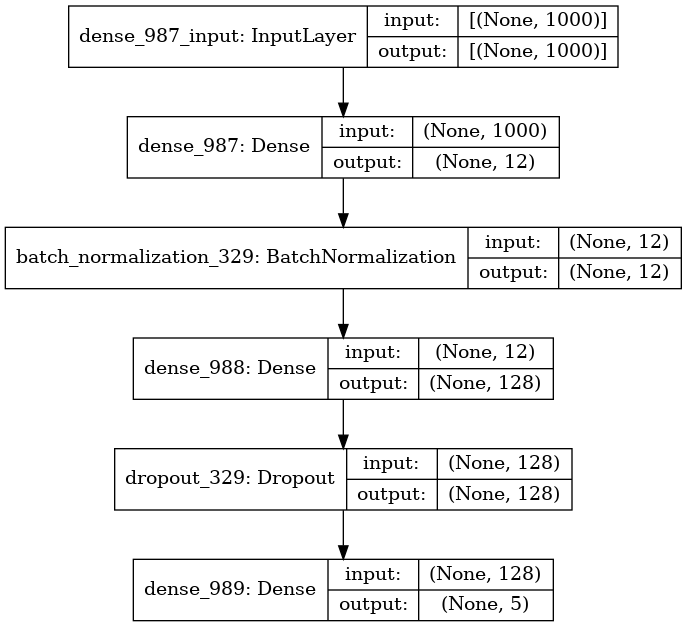

In [79]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [80]:
history = model.fit(X_train_trans, y_train, validation_data=(X_test_trans, y_test), epochs = 20, batch_size=32)

Epoch 1/20
1172/1172 [==============================] - 2s 2ms/step - loss: 1.0401 - accuracy: 0.6318 - recall: 0.4600 - val_loss: 0.4553 - val_accuracy: 0.8445 - val_recall: 0.7838
Epoch 2/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.4664 - accuracy: 0.8433 - recall: 0.7881 - val_loss: 0.4287 - val_accuracy: 0.8477 - val_recall: 0.7919
Epoch 3/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.4283 - accuracy: 0.8510 - recall: 0.7983 - val_loss: 0.4209 - val_accuracy: 0.8484 - val_recall: 0.8001
Epoch 4/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.4181 - accuracy: 0.8524 - recall: 0.7987 - val_loss: 0.4171 - val_accuracy: 0.8499 - val_recall: 0.7998
Epoch 5/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.4062 - accuracy: 0.8553 - recall: 0.8023 - val_loss: 0.4215 - val_accuracy: 0.8476 - val_recall: 0.7921
Epoch 6/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.3943 - accur

Text(0.5, 1.0, 'Results')

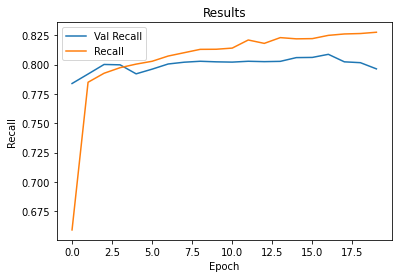

In [81]:
plt.plot(history.history['val_recall'], label='Val Recall')
plt.plot(history.history['recall'], label='Recall')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Results')

In [85]:
# model.predict(['I died a little After I saw how my mom defrosting meat'])